In [1]:
import pywt
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from img2vec_pytorch import Img2Vec
from PIL import Image
import shutil
import glob
import pandas as pd
import os

In [2]:
with open('../intermediate_data/ppg_snippets.json', 'r') as JSON:
       json_dict = json.load(JSON)
path = '../scalograms' ##TODO: make sure folder exists and folder is empty

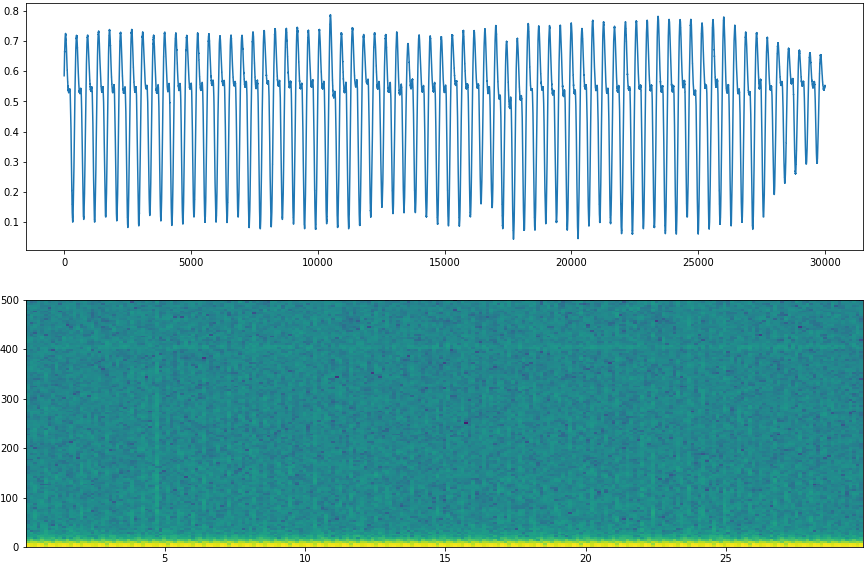

In [44]:

#fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,10))
#ax1.plot(json_dict[115]['ppg'])
#Pxx, freqs, bins, im = ax2.specgram(json_dict[115]['ppg'], Fs=1000)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
#plt.show()

In [ ]:
####https://github.com/markyasu/wavelets_to_scalograms/blob/master/concept.ipynb
def get_scalograms(json_dict, path): 
    #shutil.rmtree('../scalograms/')
    for idx, val in enumerate(json_dict):

        ppg = val['ppg']
        patientid = val['patientid']
        sbp = val['sbp']
        dbp=val['dbp']

        widths = np.arange(950, 1050)

        #(input, scale, wavelet type) 'x' is the 5s segment
        cwtmatr, freqs = pywt.cwt(ppg, widths, 'morl') 

        # first remove padding from the edges of the figure when saved by savefig. 
        # this is important for both savefig() and show(). without this there's 0.1 inches of padding on the edges by default.
        mpl.rcParams['savefig.pad_inches'] = 0

        # Then set up the axes (the plot region, or the area in which to plot things).
        # Usually there's a thin border drawn around the axes, but we turn it off with `frameon=False`.
        ax = plt.axes([0,0,1,1], frameon=False)

        # Then disable the x and y axes completely.
        # If you just say plt.axis('off'), they're still used in the computation of the image padding.
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Even though our axes (plot region) are set to cover the whole image with [0,0,1,1],
        # by default they STILL leave padding between the plotted data and the frame. 
        # Utigher=True to make sure the data gets scaled to the full extents of the axes.
        plt.autoscale(tight=True)

        #generate scalogram
        plt.imshow(cwtmatr, cmap='seismic', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
        plt.savefig(os.path.join(path, '_{}_{}_{}_scalogram.jpg'.format(patientid, sbp, dbp)), bbox_inches='tight', pad_inches=0)

In [ ]:
##get_scalograms(json_dict, path)

In [ ]:
# Initialize Img2Vec with GPU
def get_representations(path, model = 'resnet-18'):
    list_dicts = []
    img2vec = Img2Vec(cuda=False, model = model)
    for filename in glob.glob(os.path.join(path, '*.jpg')):
        im=Image.open(filename)
        # Get a vector from img2vec, returned as a torch FloatTensor
        vec = img2vec.get_vec(im, tensor=True)
        dict_temp = {}
        np_vec = vec.numpy().flatten()
        dict_temp['representation'] = np_vec
        dict_temp['patientid'] = filename.strip().split('_')[1]
        dict_temp['sbp'] = filename.strip().split('_')[2]
        dict_temp['dbp'] = filename.strip().split('_')[3]
        list_dicts.append(dict_temp)

    df_representation = pd.DataFrame(list_dicts)
    return df_representation

In [ ]:
df_representation = get_representations(path, 'resnet-18')


In [ ]:
df_representation.to_pickle('../intermediate_data/scalogram_resnet_representation.pkl')